# $\mu$-isometric diffusion maps (muiDM)

## define functions

In [1]:
%pylab inline

from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from numpy.linalg import svd, eigh
from numpy.linalg import inv, pinv, norm
from numpy.matlib import repmat

from tqdm.notebook import tqdm
#set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


In [2]:
def MK(X,Y,sigma):
    
    dist = cdist(X,Y)

    return exp(-dist**2/sigma)

In [3]:
def DM(X,sigma,dim=6):
    n = X.shape[0]
    
    K = MK(X,X,sigma)    
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
    
    return emb, S

In [4]:
def nystrom(X,Y,sample,sigma,dim=6):
    n = X.shape[0]
    m = Y.shape[0]
    
    ind1 = sample
    ind2 = delete(arange(n),ind1)
    ind = hstack((ind1,ind2))

    K = MK(X,Y,sigma) 
    K = K[ind]
    D = diag(1/sqrt(sum(K,axis=1)))
    Dsm = diag(1/sqrt(sum(K,axis=0)))

    Q = D.dot(K).dot(Dsm)
    A = Q[:m]
    B = Q[m:]
    
    uu,ss,vv = svd(A)
    AA = uu.dot(diag(1/sqrt(ss))).dot(vv)
        
    SS = A + AA.dot(B.T).dot(B).dot(AA)
    
    if dim==min(SS.shape):
        S,U = eigh(SS)
        S = S.real
        U = U.real
    else:
        U,S,VV = svds(SS,dim)
    
    S = S[::-1]
    U = U[:,::-1]*sqrt(n)
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
    
    V = Q.dot(AA).dot(U).dot(diag(1/sqrt(S)))
    V[isinf(V)] = 0
    V[isnan(V)] = 0
    
    emb = D.dot(V).dot(diag(S))
    
    emb2 = zeros((n,dim))
    emb2[ind1] = emb[:m]
    emb2[ind2] = emb[m:]
    
    return emb2

In [5]:
def muIDM(X,sigma,mu,flag=0):
    
    n = X.shape[0]
    
    if flag:
        permu = permutation(arange(n))
        X = X[permu]
    
    ind = [0]
    err = []
    
    emb = nystrom(X,X[ind],ind,sigma,dim=len(ind))
    
    for i in tqdm(range(1,n)):
        indi = ind+[i]
        embi = nystrom(X,X[indi],indi,sigma,dim=len(indi))
        
        T = pinv(emb[ind]).dot(embi[ind])
                
        err.append(norm(emb[i].dot(T) - embi[i]))
                
        if err[-1]>mu/2:
            ind = indi
            emb = embi
    
    if flag:
        tmp  = permu[1:]
        tmp1 = zeros((n,len(ind)))
        tmp2 = array([0.0]*n)
        tmp1[permu] = emb
        tmp2[permu[1:]] = array(err)
                
        emb = tmp1
        err = delete(tmp2,permu[0])
        ind = sort(permu[ind])
                
    return emb, array(ind), array(err)

### setting

In [6]:
n = 500
X = vstack((linspace(0,1,n),[0]*n)).T

sigma = 0.1
mu = 1e-6

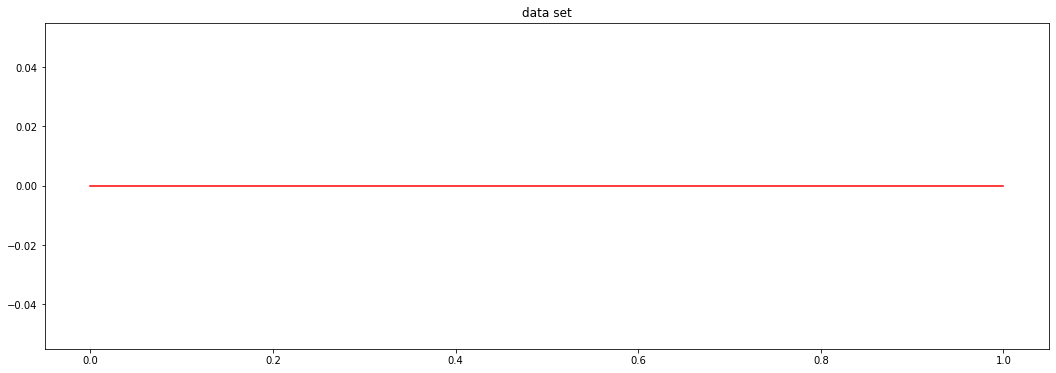

In [25]:
plot(X[:,0],X[:,1], color='r')
plt.gcf().set_size_inches(18,6)
plt.title('data set')
plt.show()

### mu-isometric DM

In [7]:
emb, ind, err = muIDM(X,sigma,mu)

  0%|          | 0/499 [00:00<?, ?it/s]

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


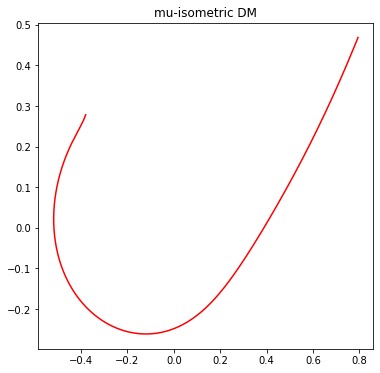

In [8]:
plot(emb[:,1],emb[:,2], color='r')
plt.gcf().set_size_inches(6,6)
plt.title('mu-isometric DM')
plt.show()

landmark set size:  65


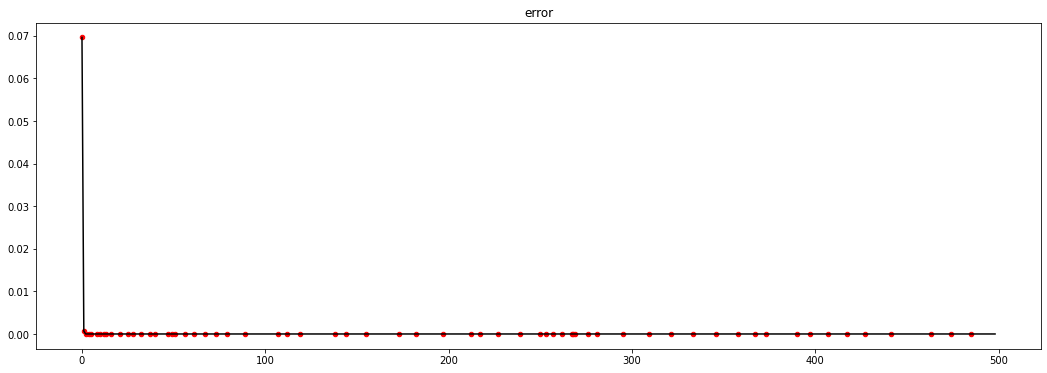

In [9]:
print('landmark set size: ',len(ind))
err = array(err)
plot(arange(n-1),err,color='k')

tmp = argwhere(err>mu/2)
tmp = tmp.reshape(1,size(tmp))[0].tolist()
scatter(tmp,err[tmp],color='r',s=20)

plt.gcf().set_size_inches(18,6)
plt.title('error')
plt.show()

### (check if our result align with nystrom embedding using the chosen subset)

In [10]:
embnys = nystrom(X,X[ind],ind,sigma,dim=25)

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


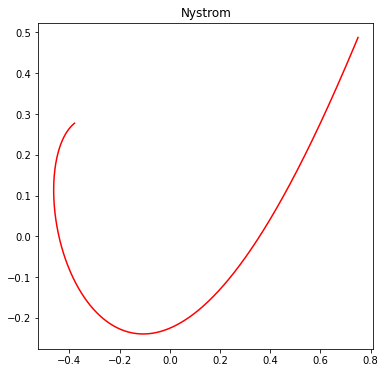

In [13]:
plot(-embnys[:,1],embnys[:,2], color='r')
plt.gcf().set_size_inches(6,6)
plt.title('Nystrom')
plt.show()

### mu-isometric DM (first randomly permute our data set)

In [14]:
emb2, ind2, err2 = muIDM(X,sigma,mu,flag=1)

  0%|          | 0/499 [00:00<?, ?it/s]

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


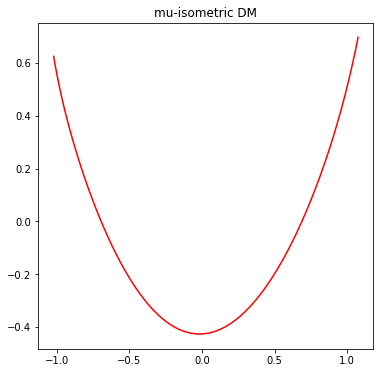

In [15]:
plot(emb2[:,1],emb2[:,2], color='r')
plt.gcf().set_size_inches(6,6)
plt.title('mu-isometric DM')
plt.show()

landmark set size:  35


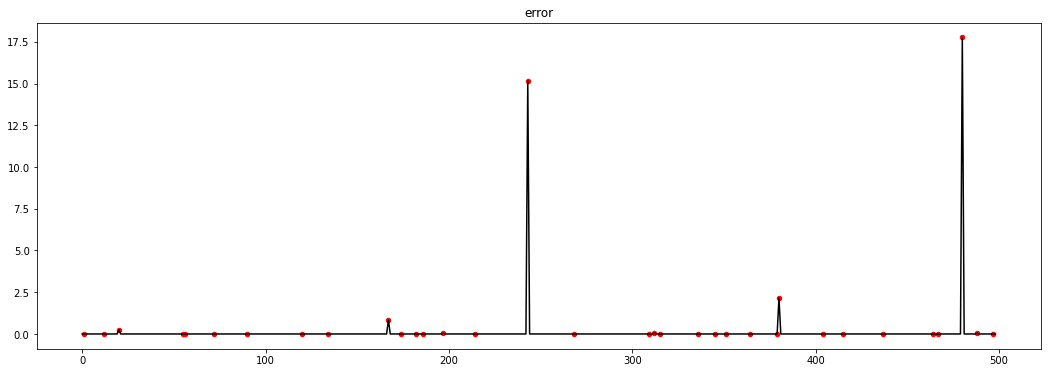

In [16]:
print('landmark set size: ',len(ind2))
err2 = array(err2)
plot(arange(n-1),err2,color='k')

tmp = argwhere(err2>mu/2)
tmp = tmp.reshape(1,size(tmp))[0].tolist()
scatter(tmp,err2[tmp],color='r',s=20)

plt.gcf().set_size_inches(18,6)
plt.title('error')
plt.show()

### (check if our result align with nystrom embedding using the chosen subset)

In [17]:
embnys2 = nystrom(X,X[ind2],ind2,sigma,dim=25)

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


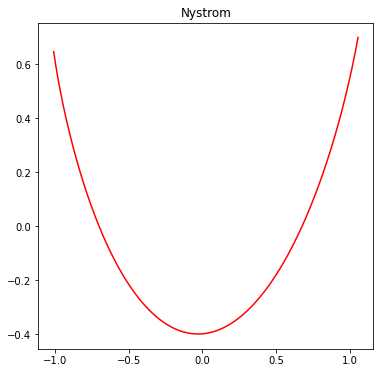

In [18]:
plot(embnys2[:,1],embnys2[:,2], color='r')
plt.gcf().set_size_inches(6,6)
plt.title('Nystrom')
plt.show()

## Nystrom with uniformly selected landmarks

In [19]:
m = 50
indu = arange(n)[::int(ceil(n/m))][:m]

embnys3 = nystrom(X,X[indu],indu,sigma,dim=25)

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


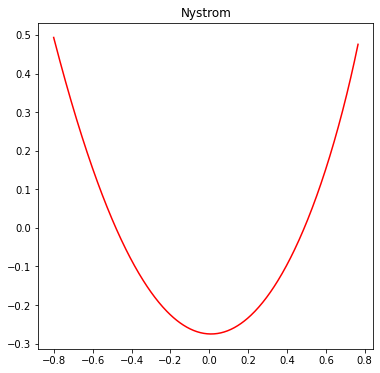

In [20]:
plot(embnys3[:,1],embnys3[:,2], color='r')
#plot(emb2[:,1],emb2[:,2], color='b', label='original DM')

plt.gcf().set_size_inches(6,6)
plt.title('Nystrom')
plt.show()

## original DM

In [21]:
embdm,_ = DM(X,sigma)

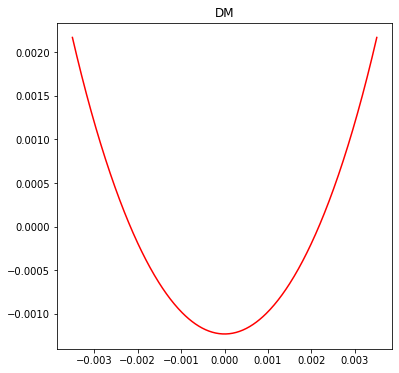

In [22]:
plot(embdm[:,1],embdm[:,2], color='r')
plt.gcf().set_size_inches(6,6)
plt.title('DM')
plt.show()